In [1]:
### First, I import all the required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

#import the other files
from pyModules.CalibrateCamera import calibrate_camera
from pyModules.CalibrateCamera import undistort_image
# Color related functions
from pyModules.ColorSpace import combine_thresholds

# Transform Fucntions
from pyModules.PerspectiveTransform import warp_picture
from pyModules.PerspectiveTransform import get_matrixes

# Line Functions
from pyModules.LineFit import find_lane_pixels
from pyModules.LineFit import fit_polynomial

# Other Utilities 
from pyModules.Utilities import measure_curvature_real
from pyModules.Utilities import offset_calculation
from pyModules.Utilities import print_on_image

Text(0.5,1,'Destination Image')

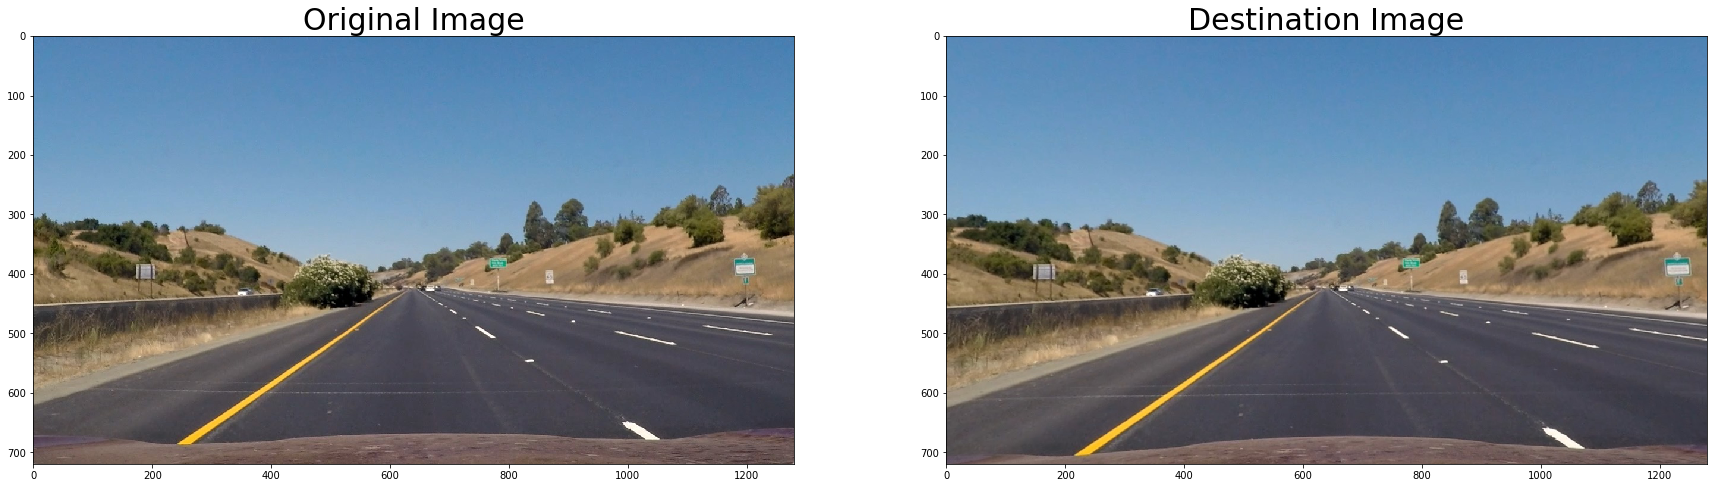

In [2]:
## calibrate Camera:
mtx_camera, dist_camera = calibrate_camera()

## Load Image for testing
## Get Image and Undistrot Image
img = cv2.imread('test_images/straight_lines1.jpg')
img_undist = undistort_image(img, mtx_camera, dist_camera)

cv2.imwrite('output_images/undist_image.png', img_undist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
ax1.imshow(img[...,::-1])
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_undist[...,::-1], cmap='gray')
ax2.set_title('Destination Image', fontsize=30)

Text(0.5,1,'Combined Image')

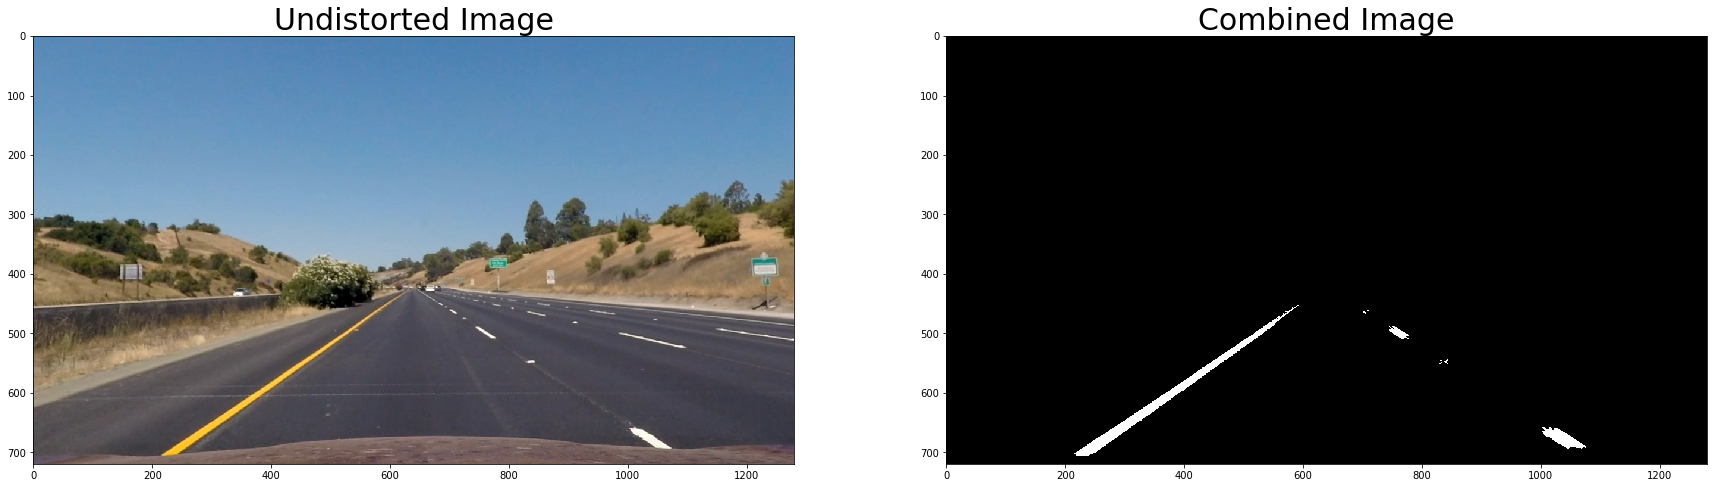

In [3]:
combined_img = combine_thresholds(img_undist)
cv2.imwrite('output_images/combined_image.png', combined_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
ax1.imshow(img_undist[...,::-1])
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(combined_img, cmap='gray')
ax2.set_title('Combined Image', fontsize=30)

Text(0.5,1,'Warped Image')

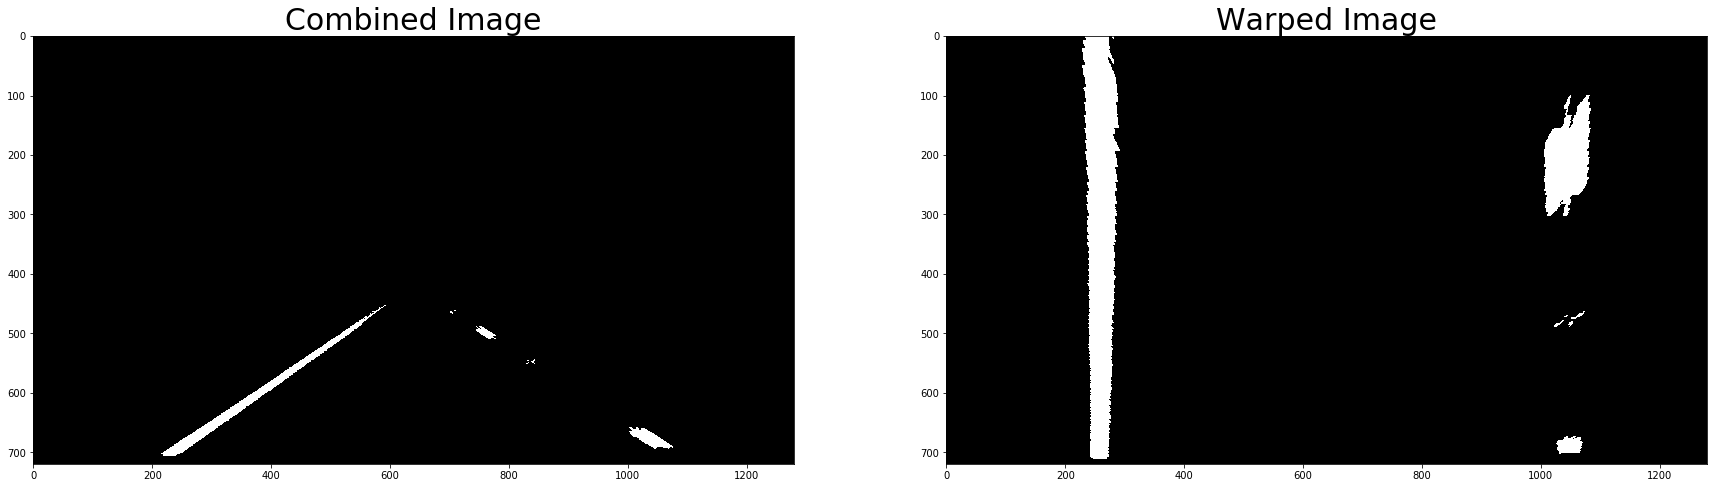

In [4]:
img_size = (img.shape[1], img.shape[0])
mtx_persp, mtx_persp_inv = get_matrixes(img_size)
img_warped = warp_picture(combined_img, mtx_persp)
cv2.imwrite('output_images/warped_image.png', img_warped)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
ax1.imshow(combined_img, cmap='gray')
ax1.set_title('Combined Image', fontsize=30)
ax2.imshow(img_warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=30)

Text(0.5,1,'Lines Image')

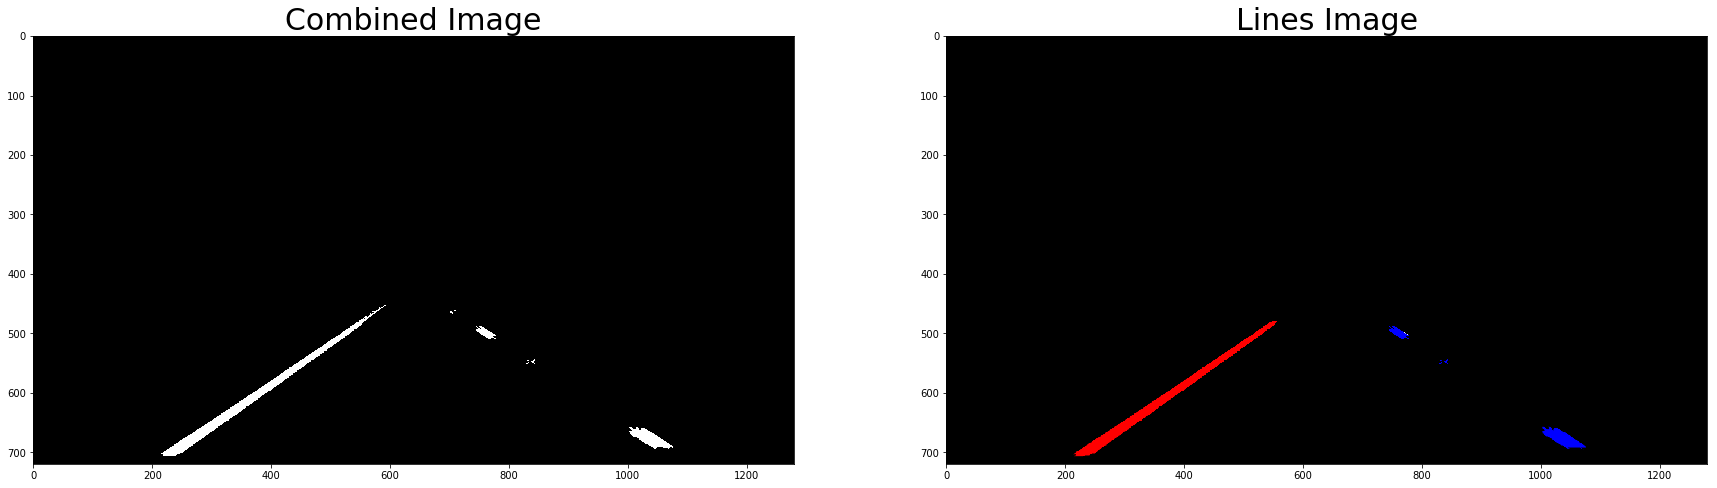

In [5]:
## Detect the Lines in the warped Image
### Get the Polynomiyal for the left and right side
### also get the amount of pixels detected to use later as a weighting.
### The more pixles detected the higher the accuracy.
out_img, left_poly, right_poly, poly, leftx, rightx = fit_polynomial(img_warped)

## Getting Curvature for left and right side
left_r, right_r = measure_curvature_real(poly, left_poly, right_poly)

## Weight the curvature ratios based on the amount of pixles
weighted_r = (((left_r * leftx.shape[0]) + (right_r * rightx.shape[0])) / (((leftx.shape[0] + rightx.shape[0]))))

## Print the lines back into the image:
offset = offset_calculation(leftx, rightx, img_size)
lines_img = warp_picture(out_img, mtx_persp_inv)
cv2.imwrite('output_images/lines_image.png', lines_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
ax1.imshow(combined_img, cmap= 'gray')
ax1.set_title('Combined Image', fontsize=30)
ax2.imshow(lines_img, cmap='gray')
ax2.set_title('Lines Image', fontsize=30)

Text(0.5,1,'Final Image')

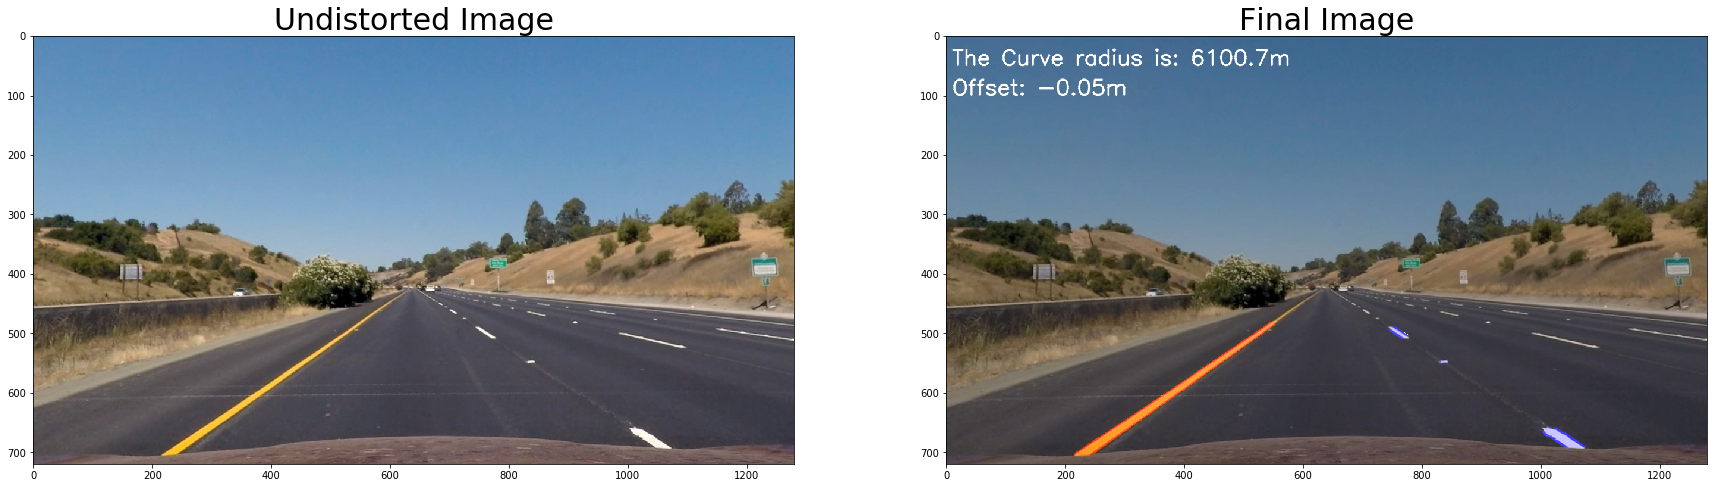

In [6]:
output_img = cv2.addWeighted(img_undist[...,::-1], .8, lines_img, 0.9, 0.2)
print_on_image(output_img, weighted_r, offset)

cv2.imwrite('output_images/final_image.png', output_img[...,::-1])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
ax1.imshow(img_undist[...,::-1])
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(output_img, cmap='gray')
ax2.set_title('Final Image', fontsize=30)

In [7]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

class Line:
    def __init__(self):
        self.available = False
        self.average_coefficient = None
        self.coefficients = []

    def calc_average(self, coefficient):
        self.coefficients.append(coefficient)
        if len(self.coefficients) > 5:
            self.coefficients = self.coefficients[1:6]
            
        self.avg_coeff = np.average(self.current_coeffs)



In [8]:
def video_pipeline(image):
    img_undist = undistort_image(image, mtx_camera, dist_camera)
    combined_img = combine_thresholds(img_undist)

    img_size = (image.shape[1], image.shape[0])
    mtx_persp, mtx_persp_inv = get_matrixes(img_size)

    warped = warp_picture(combined_img, mtx_persp)

    # Detect the Lines in the warped Image
    out_img, left_poly, right_poly, poly, leftx, rightx = fit_polynomial(warped)

    # Getting Curvature for left and right side
    left_r, right_r = measure_curvature_real(poly, left_poly, right_poly)
    # Weight the curvature ratios based on the amount of pixels
    weighted_r = (((left_r * leftx.shape[0]) + (right_r * rightx.shape[0])) / (leftx.shape[0] + rightx.shape[0]))
    
    offset = offset_calculation(leftx, rightx, img_size)
    lines_img = warp_picture(out_img, mtx_persp_inv)

    # Print the lines back into the image:
    print_on_image(img_undist, weighted_r, offset)
    output_img = cv2.addWeighted(img_undist, 1, lines_img, 0.8, 0)

    return output_img
    

In [ ]:
mtx_camera, dist_camera = calibrate_camera()

output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(video_pipeline)#NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


 99%|█████████▉| 125/126 [01:03<00:00,  1.95it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))